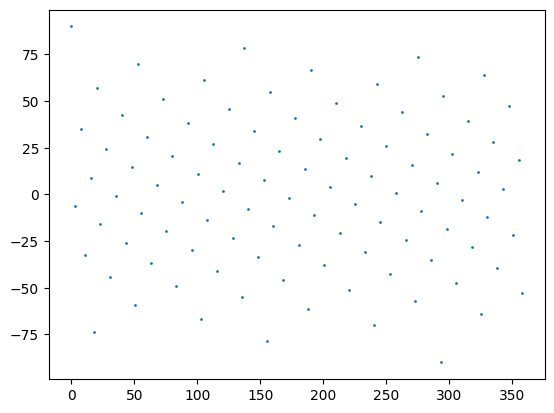

100 412.52961249419275 deg2


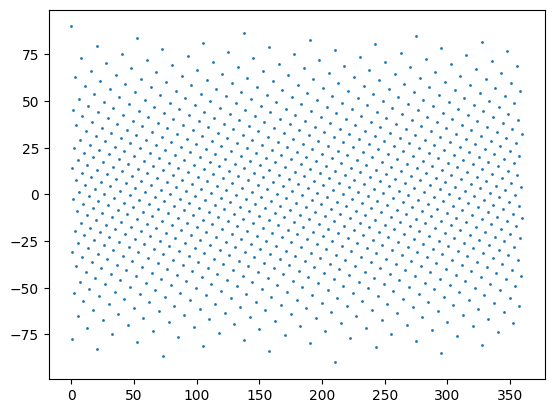

1000 41.25296124941928 deg2


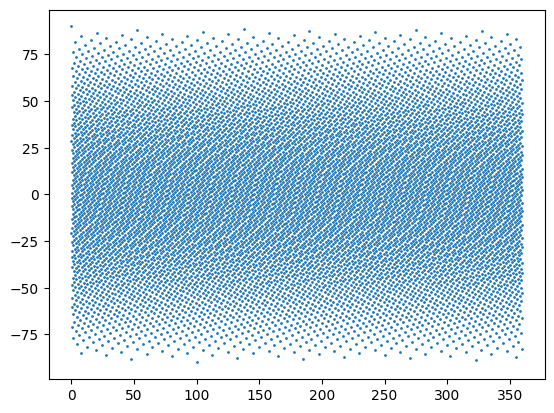

10000 4.1252961249419275 deg2


In [1]:
import astropy.coordinates as ac
import astropy.units as au
import numpy as np
import pylab as plt

def get_num_pointings(pointing_separation: au.Quantity) -> int:
    if not pointing_separation.unit.is_equivalent('deg'):
        raise ValueError("Pointing separation must be in degrees")
    # Sky area of a pointing
    pointing_area = 2. * np.pi * (1. - np.cos(pointing_separation.to('rad')))
    all_sky_area = 4. * np.pi
    pointings_per_sky = int(np.ceil(all_sky_area / pointing_area))
    return pointings_per_sky


def fibonacci_celestial_sphere(n: int) -> ac.ICRS:
    """
    Generates 'n' points on the surface of a sphere using the Fibonacci sphere algorithm.

    Args:
        n (int): Number of points to generate.

    Returns:
        lon (jnp.ndarray): Array of longitudes in radians.
        lat (jnp.ndarray): Array of latitudes in radians.
    """
    # Golden angle in radians
    golden_angle = np.pi * (3.0 - np.sqrt(5.0))  # Approximately 2.39996 radians

    # Indices from 0 to n-1
    indices = np.arange(n)

    # Compute y coordinates (latitude component)
    y = 1 - (2 * indices) / (n - 1)  # y ranges from 1 to -1

    # Compute latitude in radians
    lat = np.arcsin(y)

    # Compute longitude in radians
    theta = golden_angle * indices
    lon = theta % (2 * np.pi)  # Ensure longitude is within [0, 2π)

    return ac.ICRS(lon * au.rad, lat * au.rad)


for n in [100, 1000, 10000]:
    pointings = fibonacci_celestial_sphere(n=n)
    plt.scatter(pointings.ra, pointings.dec, s=1)
    plt.show()

    mean_area = (4 * np.pi / n) * au.rad ** 2
    print(n, mean_area.to('deg^2'))